<a href="https://colab.research.google.com/github/newgabo/TP2-AA/blob/master/TP2_AA_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import's

In [23]:
from io import BytesIO

import pickle
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Notación Científica a Decimal
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Features

In [25]:
#df_features = pkl.load(open( "./features.p", "rb" ))
#df_features.shape

df_features.group.value_counts()

train         18620
testing        2552
validation     2494
Name: group, dtype: int64

In [24]:
# Desde nuestro repo!
github_Link_ = 'https://github.com/newgabo/TP2-AA/blob/master/feat_numbers.p?raw=true'
file_ = BytesIO(requests.get(github_Link_).content)
df_features = pickle.load(file_)

df_features.shape

(23666, 81)

In [ ]:
df_features.head(3)

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,...,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,file,group
0,-447.013484,82.107158,30.128931,37.495112,26.410458,19.349560,0.220880,13.787186,-2.090889,10.186531,-7.550286,10.405959,0.019915,105.243203,66.167088,31.379087,17.044830,16.423239,8.988007,9.500313,9.899634,9.093648,6.358469,9.571304,5.839290,0.020091,2.496440,2.679139,1.382694,0.637334,0.352528,-0.074789,-0.395724,0.065883,0.209853,0.001462,-0.285006,-0.134541,0.000150,30.677672,...,16.546769,10.995023,9.365660,8.321029,6.260240,6.316014,6.087133,5.224652,6.299041,4.700034,0.005500,-0.892144,-0.598645,-0.007513,0.030784,0.059811,0.011742,-0.035612,-0.153660,0.043779,0.055412,-0.318548,-0.205389,0.000004,27.638152,17.219400,17.457224,12.668412,12.201276,9.884946,6.972104,6.423280,8.005895,6.840991,7.951120,6.086549,0.004210,zero,zero/b087aa0e_nohash_3.wav,0
1,-467.465407,106.485956,-15.164009,-15.916635,-14.513851,-0.943692,-22.114575,-2.098791,-15.078180,-5.339973,-2.508492,-4.010259,0.013808,143.690633,70.235703,41.396458,40.314901,12.078412,11.622522,22.692563,9.660152,21.297017,13.316683,17.371868,9.550928,0.015601,-7.601924,0.236934,0.089262,-2.493223,-0.741256,-1.250152,-0.836076,-0.696116,0.169622,0.121786,0.354079,-0.369492,-0.000327,39.752012,...,20.762736,13.504974,7.302112,7.357263,9.344045,5.285964,8.008044,7.523747,8.351461,6.590797,0.004400,1.047351,0.668475,0.700569,0.555578,0.056259,0.025067,-0.052724,0.376561,0.467289,-0.150500,-0.275497,-0.094380,0.000007,26.816543,19.741062,18.224348,13.530634,8.566786,8.785448,10.018413,5.969772,7.914729,9.536014,8.486372,7.918756,0.002291,zero,zero/1a892463_nohash_1.wav,0
2,-387.342123,103.399141,19.127111,14.150534,4.236167,2.916593,-8.341188,-4.871776,0.061372,-0.830761,-3.717342,2.287600,0.012329,64.780687,35.179736,33.911680,21.783957,12.907511,6.429770,16.483586,13.218573,10.295328,8.537958,6.550306,5.131923,0.007889,-0.205598,0.652267,-0.219559,0.447939,-0.305171,-0.062667,-0.035065,-0.005668,-0.274419,-0.224229,-0.301606,-0.081482,-0.000002,22.896360,...,13.689751,14.482363,9.326665,5.371619,8.143473,6.305598,7.962056,4.619381,3.983173,4.335403,0.002344,-0.037434,-0.070952,0.116700,-0.117510,-0.021160,0.002680,-0.007003,0.065581,0.036829,0.015601,-0.082768,-0.234645,0.000015,21.679999,12.490425,10.516682,13.017614,10.620068,6.833076,9.695476,7.443200,8.834083,4.591547,4.575489,5.140761,0.001743,zero,zero/fb2f3242_nohash_0.wav,0


In [ ]:
# Algunos controles para yo entender la data nuevamente
df_features.groupby('target').count()

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,group
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
eight,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352,2352
five,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357,2357
four,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372,2372
nine,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364
one,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370,2370
seven,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377,2377
six,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369,2369
three,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,2356,235

In [26]:
df_features.groupby('group').count()

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,file
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
testing,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552
train,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620
validation,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494


# Modelos

In [27]:
df_train = df_features[df_features['group'] == 'train']

del df_train['group']
del df_train['file']
len(df_train.index)

18620

In [29]:
features = df_train.loc[:, df_train.columns != 'target'].columns
target = 'target'

x_train, y_train = df_train[features].values, df_train[target].values

In [30]:
df_test = df_features[df_features['group'] == 'testing']

del df_test['group']
del df_test['file']
len(df_test.index)

2552

In [31]:
x_test, y_test = df_test[features].values, df_test[target].values

### Bagging Parameters


*   n_estimators
*   max_features
*   oob_score

### Tree-specific Parameters


*   max_depth
*   min_samples_split
*   min_samples_leaf
*   class_weight (balanced)



### Naive Bayes

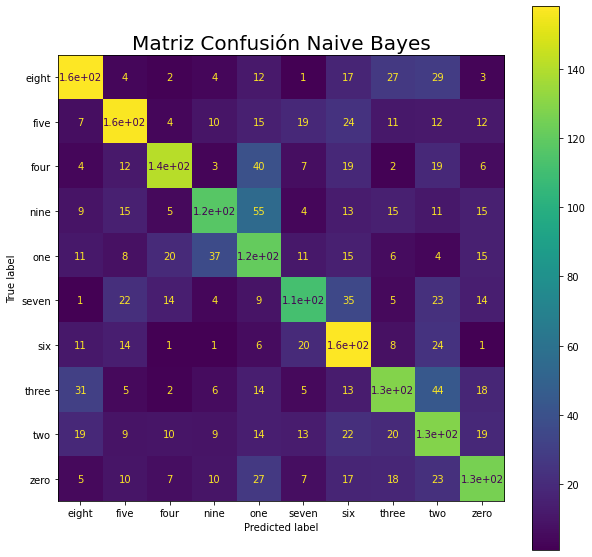

Accuracy Training : 0.541
Accuracy Test: 0.528


In [32]:
clf_nb_ = GaussianNB()
clf_nb_.fit(x_train, y_train)

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf_nb_, x_test, y_test, ax = ax)
plt.title("Matriz Confusión Naive Bayes", size=20)
plt.show()

print("Accuracy Training : {:.3f}".format(clf_nb_.score(x_train, y_train)))
print("Accuracy Test: {:.3f}".format(clf_nb_.score(x_test, y_test)))

### Random Forest

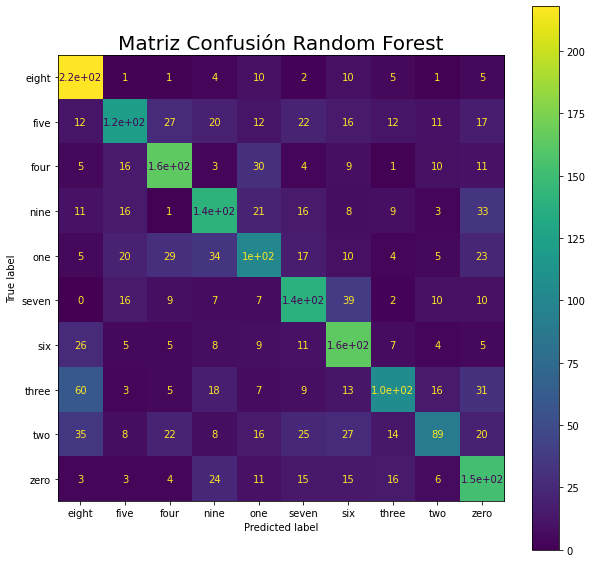

Accuracy training : 0.595
Accuracy test: 0.547
Best Random Forest Score 0.5695488721804511 with params {'bootstrap': True, 'max_depth': 5, 'max_features': 6, 'n_estimators': 100}


In [33]:
parameters = {'n_estimators':range(100, 200, 500), 'max_depth':range(5,10,15), 'bootstrap':[True, False], 'max_features': [6, 8, 10]}
clf_rf_ = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, scoring='accuracy')
clf_rf_.fit(x_train, y_train)

clf_rf_be_ = clf_rf_.best_estimator_
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf_rf_be_, x_test, y_test, ax = ax)
plt.title("Matriz Confusión Random Forest", size=20)
plt.show()

print("Accuracy training : {:.3f}".format(clf_rf_be_.score(x_train, y_train)))
print("Accuracy test: {:.3f}".format(clf_rf_be_.score(x_test, y_test)))
print("Best Random Forest Score %s with params %s" %(clf_rf_.best_score_, clf_rf_.best_params_))

### Gradient Boosting 

1.   Initial Model (weak estimator)
2.   New Model fits to residuals
3.   New additive model
4.   Repeat n times or until error is small enough
5.   Final additive model

A diferencia de los modelos por Votación, en Gradient Boosting los estimadores no se combinan mediante votación o promedios, sino por suma. Se debe a que el primer modelo se ajusta a la variable objetivo y el resto son estimaciones de los errores residuales.

Parámetros:
*   n_estimators
*   learning_rate
*   max_depth
*   min_samples_split
*   min_samples_leaf
*   max_features

En Gradient Boosting se recomiendan utilizar todos los parámetros.

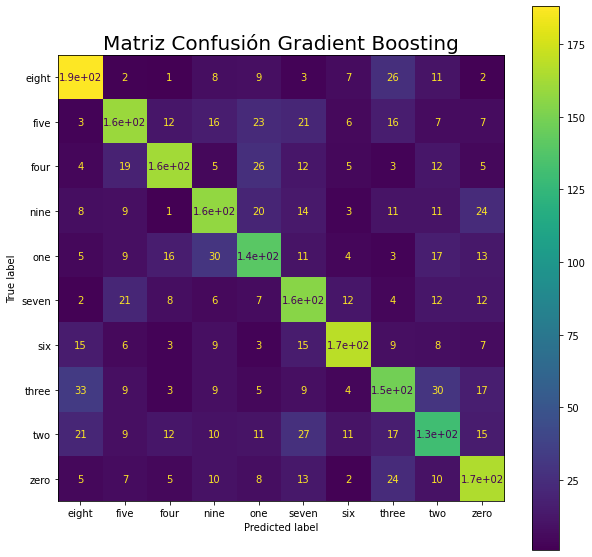

Accuracy training : 0.880
Accuracy test: 0.618
Best Gradient Boosting Score 0.6395273899033297 with params {'learning_rate': 0.01, 'max_depth': 8, 'max_features': 10, 'n_estimators': 10}


In [36]:
"""
parameters = {'n_estimators':range(100, 200), 'learning_rate': np.linspace(0 ,0.1), 'max_features': [6, 8, 10], 
              'n_iter_no_change': [5], 'tol': [0.01]} 

parameters = {'n_estimators':range(100, 200), 
              'learning_rate': [0 ,0.1], 
              'n_iter_no_change': [5], 'tol': [0.01]}    
"""
     
parameters = {
    "learning_rate": [0, 0.01],
    "max_depth":[3,5,8],
    'max_features': [6, 8, 10],
    "n_estimators":[10]
    }          
clf_gb_ = GridSearchCV(GradientBoostingClassifier(), parameters, n_jobs=10, scoring='accuracy')
clf_gb_.fit(x_train, y_train)

clf_gb_be_ = clf_gb_.best_estimator_
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf_gb_, x_test, y_test, ax = ax)
plt.title("Matriz Confusión Gradient Boosting", size=20)
plt.show()

print("Accuracy training : {:.3f}".format(clf_gb_.score(x_train, y_train)))
print("Accuracy test: {:.3f}".format(clf_gb_.score(x_test, y_test)))
print("Best Gradient Boosting Score %s with params %s" %(clf_gb_.best_score_, clf_gb_.best_params_))

### Multilayer Perceptron

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


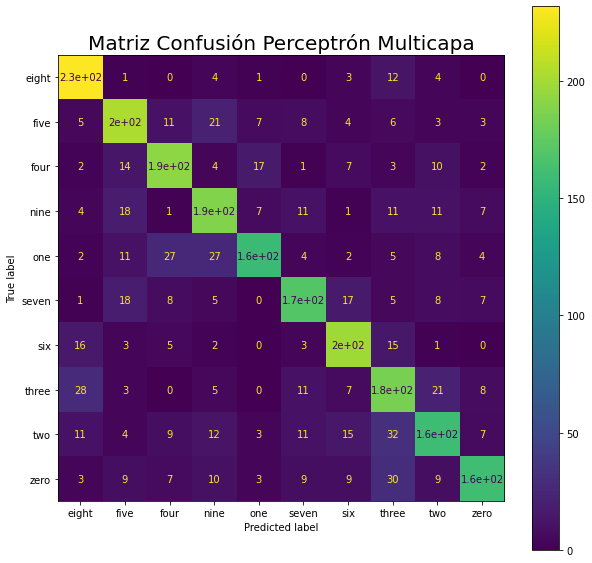

Accuracy training : 0.842
Accuracy test: 0.724
Best Multilayer Perceptron Score 0.765950590762621 with params {'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [37]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

clf_mlp_ = GridSearchCV(MLPClassifier(max_iter=100), parameter_space, n_jobs=-1, scoring='accuracy')
clf_mlp_.fit(x_train, y_train)

clf_mlp_be_ = clf_mlp_.best_estimator_

# En el TP se menciona lo siguiente:
# Elegir el numero de neuronas de la capa utilizando Random Search
# por lo tanto, deberíamos hacer uso de RandomizedSearchCV()? Yo venía haciendo uso de GridSearch()
#
# Qué opinan?

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf_mlp_, x_test, y_test, ax = ax)
plt.title("Matriz Confusión Perceptrón Multicapa", size=20)
plt.show()

print("Accuracy training : {:.3f}".format(clf_mlp_.score(x_train, y_train)))
print("Accuracy test: {:.3f}".format(clf_mlp_.score(x_test, y_test)))
print("Best Multilayer Perceptron Score %s with params %s" %(clf_mlp_.best_score_, clf_mlp_.best_params_))

# Comparación performance

Text(0.5, 1.0, 'Comparación Modelos: Train&Test Performance')

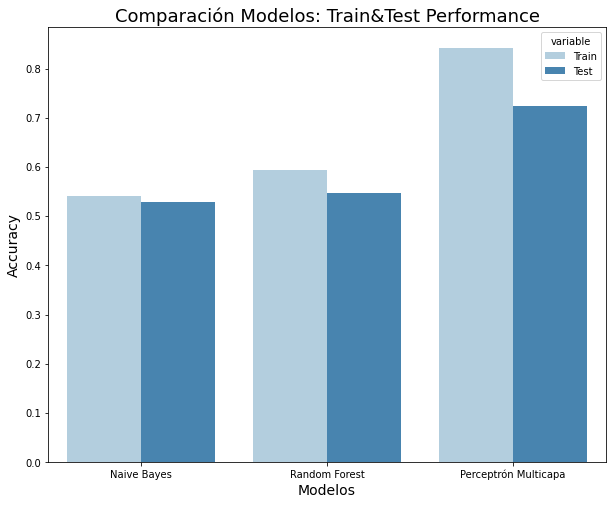

In [39]:
dict_performance_ = {'Modelo': ['Naive Bayes', 'Random Forest', 'Perceptrón Multicapa'], 
     'Train': [clf_nb_.score(x_train, y_train), 
               clf_rf_be_.score(x_train, y_train),
               #clf_gb_.score(x_train, y_train),
               clf_mlp_.score(x_train, y_train)
               ], 
     'Test':  [clf_nb_.score(x_test, y_test),
               clf_rf_be_.score(x_test, y_test),
               #clf_gb_.score(x_test, y_test),
               clf_mlp_.score(x_test, y_test)
               ]}
df_performance_ = pd.DataFrame(data=dict_performance_)

plt.figure(figsize=(10, 8))
sns.barplot(x="Modelo", y="value", hue="variable", data=pd.melt(df_performance_, id_vars=['Modelo']), palette="Blues")
plt.ylabel("Accuracy", size=14)
plt.xlabel("Modelos", size=14)
plt.title("Comparación Modelos: Train&Test Performance", size=18)

# Evaluación de Ruido

In [ ]:
noise_levels_ = np.arange(0, 0.1, 0.01)

In [ ]:
df_validation = df_features[df_features['group'] == 'validation']

del df_validation['group']
del df_validation['file']
len(df_validation.index)

In [ ]:
t = np.linspace(0,1,44100)
audio = np.sin(1200*t)
ruido = np.random.normal(size=audio.shape)
senal = ruido + audio

for noise in noise_levels_:
  ...